In [1]:
from spacerocks.spacerock import SpaceRock, RockCollection
from spacerocks.observing import Observatory, DetectionCatalog
from spacerocks.spice import SpiceKernel
from spacerocks.time import Time

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd

import numpy as np

kernel = SpiceKernel()
kernel.load("/Users/kjnapier/data/spice/latest_leapseconds.tls")
kernel.load("/Users/kjnapier/data/spice/de440s.bsp")

In [2]:
ds = [72.81, 74.81, 76.81, 82.15]

In [3]:
now = Time.now()

In [4]:
DEG_TO_RAD = np.pi / 180

In [5]:
class Pointing:

    def __init__(self, ra: float, dec: float, epoch: Time, fov_radius: float = 0.75 * DEG_TO_RAD):
        self.ra = ra
        self.dec = dec
        self.fov_radius = fov_radius
        self.epoch = epoch

    def contains(self, obs: DetectionCatalog) -> bool:
        ras = obs.ra
        decs = obs.dec

        # Calculate the angular distance between the pointing and the observations
        # This is the distance on the sky in radians
        d = np.sqrt((ras - self.ra)**2 + (decs - self.dec)**2)
        visible = d < self.fov_radius
        return visible

In [6]:
o = Observatory.from_obscode("T09")

In [6]:
model = pd.read_csv("/Users/kjnapier/data/research/model_KB_0.csv")

In [74]:
resonant = model.Comments.apply(lambda x: "Scattering" in x)

In [75]:
resonant_model = model[resonant]
nonresonant_model = model[~resonant]

In [76]:
resonant_model

,a,e,inc,node,peri,Manom,H,Comments,objid
4,822.228,0.958,7.402,252.4,235.5,329.5,12.78,Scattering,fc1db9e9f4e642e197d08f2043980317
6,603.717,0.942,10.478,357.6,355.9,296.3,13.51,Scattering,c73097522d554222a937a1abe09cb828
12,396.527,0.893,9.801,10.7,21.7,45.5,10.97,Scattering,af4d96b953634c039f38756d4879e68c
17,237.678,0.834,15.856,91.9,281.9,144.3,13.86,Scattering,b70834c9d18e4d878527912abec7a4e2
23,148.313,0.763,19.097,265.2,252.3,201.4,13.79,Scattering,11e1c58438e441608129c9d26964a558
...,...,...,...,...,...,...,...,...,...
26499988,267.386,0.877,15.997,233.7,63.3,351.3,13.10,Scattering,84381e698a804affac8cb9127f1cf6cf
26499991,474.133,0.923,3.728,239.3,79.6,357.4,13.74,Scattering,27165297370042738853ab885c5d1e95
26499992,967.375,0.950,29.482,334.9,18.5,236.8,12.57,Scattering,ce7aeb6a0927444383563b672f76063a
26499994,887.284,0.962,15.261,306.5,313.5,60.7,13.18,Scattering,b597e8de0efa447ba90f82c65a6d4b9b


In [77]:
model_epoch = Time(2458540.635902778, 'utc', 'jd')

In [90]:
rocks = RockCollection()
for row in model.itertuples():
    rock = SpaceRock.from_kepler(name=row.objid, 
                                 a=row.a, 
                                 e=row.e, 
                                 inc=row.inc * DEG_TO_RAD,
                                 arg=row.peri * DEG_TO_RAD,
                                 node=row.node * DEG_TO_RAD,
                                 M=(row.Manom * DEG_TO_RAD) % (2 * np.pi),
                                 epoch=model_epoch)

    rock.set_absolute_magnitude(row.H)
    rocks.add(rock)

In [91]:
neptune = SpaceRock.from_spice("Neptune Barycenter", model_epoch, frame="ECLIPJ2000")

In [92]:
obs = rocks.observe(o.at(now))

In [93]:
keep = obs.mag < 28

In [94]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# ax.scatter(rocks.x[keep], rocks.y[keep], s=1, alpha=0.5, color='grey')
# ax.scatter(neptune.x, neptune.y, s=10, color='blue')
# # draw a circle with radius 60
# circle = plt.Circle((0, 0), 70, color='r', fill=False)
# ax.add_artist(circle)

# circle = plt.Circle((0, 0), 80, color='r', fill=False)
# ax.add_artist(circle)
# ax.set_aspect('equal')

In [95]:
pointing_0 = Pointing(287.33743 * DEG_TO_RAD, -20.12725 * DEG_TO_RAD, Time(58998.5 + 2400000.5, 'utc', 'jd'))
pointing_1 = Pointing(288.71466 * DEG_TO_RAD, -20.37960 * DEG_TO_RAD, Time(58999.5 + 2400000.5, 'utc', 'jd'))
pointing_2 = Pointing(288.66147 * DEG_TO_RAD, -20.05024 * DEG_TO_RAD, Time(59020.5 + 2400000.5, 'utc', 'jd'))




deep_pointing_1 = Pointing(352.42444 * DEG_TO_RAD, -3.82797 * DEG_TO_RAD, Time(2458755.513, 'utc', 'jd'), fov_radius=1.1 * DEG_TO_RAD)
deep_pointing_2 = Pointing(353.12082 * DEG_TO_RAD, -5.50267 * DEG_TO_RAD, Time(2458754.511, 'utc', 'jd'), fov_radius=1.1 * DEG_TO_RAD)

pointings = [pointing_0, pointing_1, pointing_2, deep_pointing_1, deep_pointing_2]

In [96]:
rocks.change_frame("J2000")

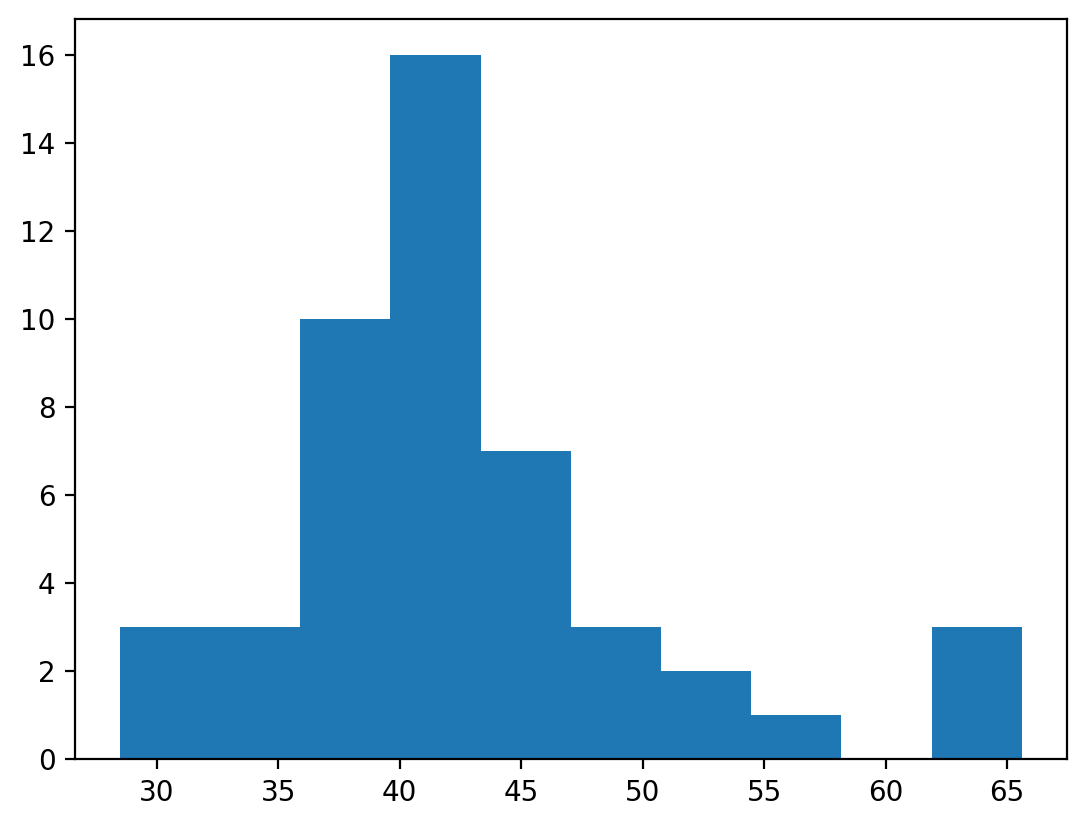

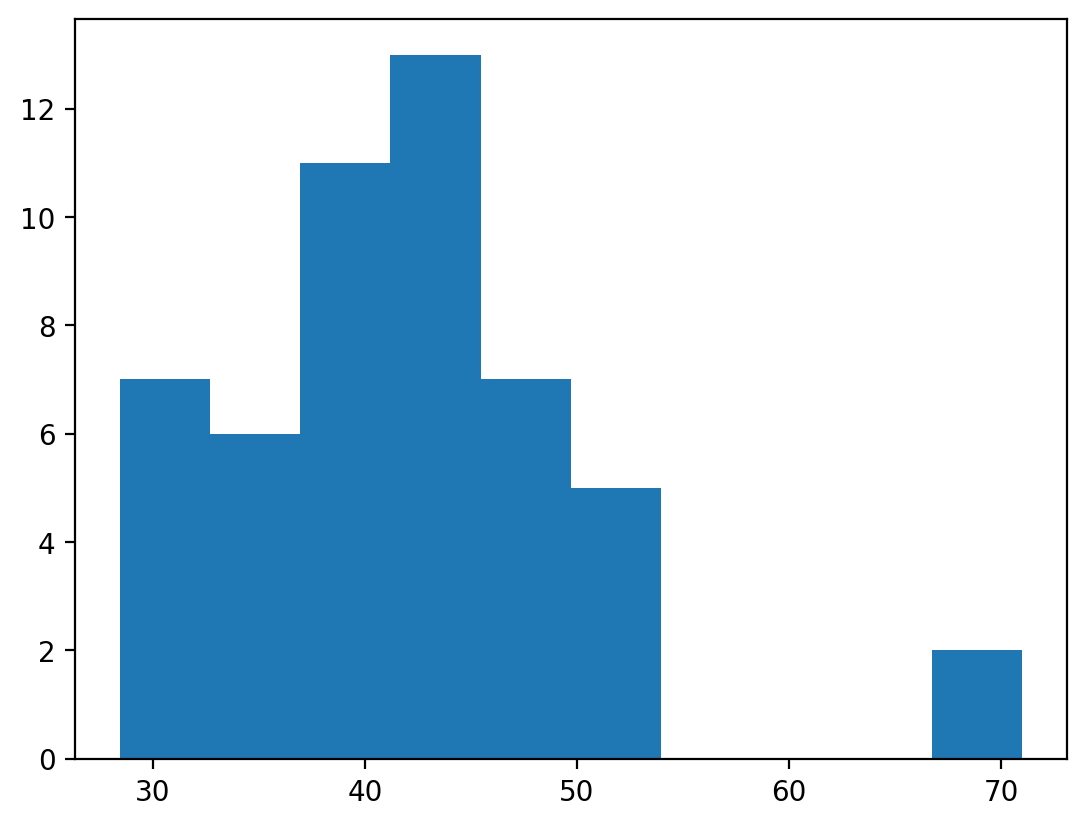

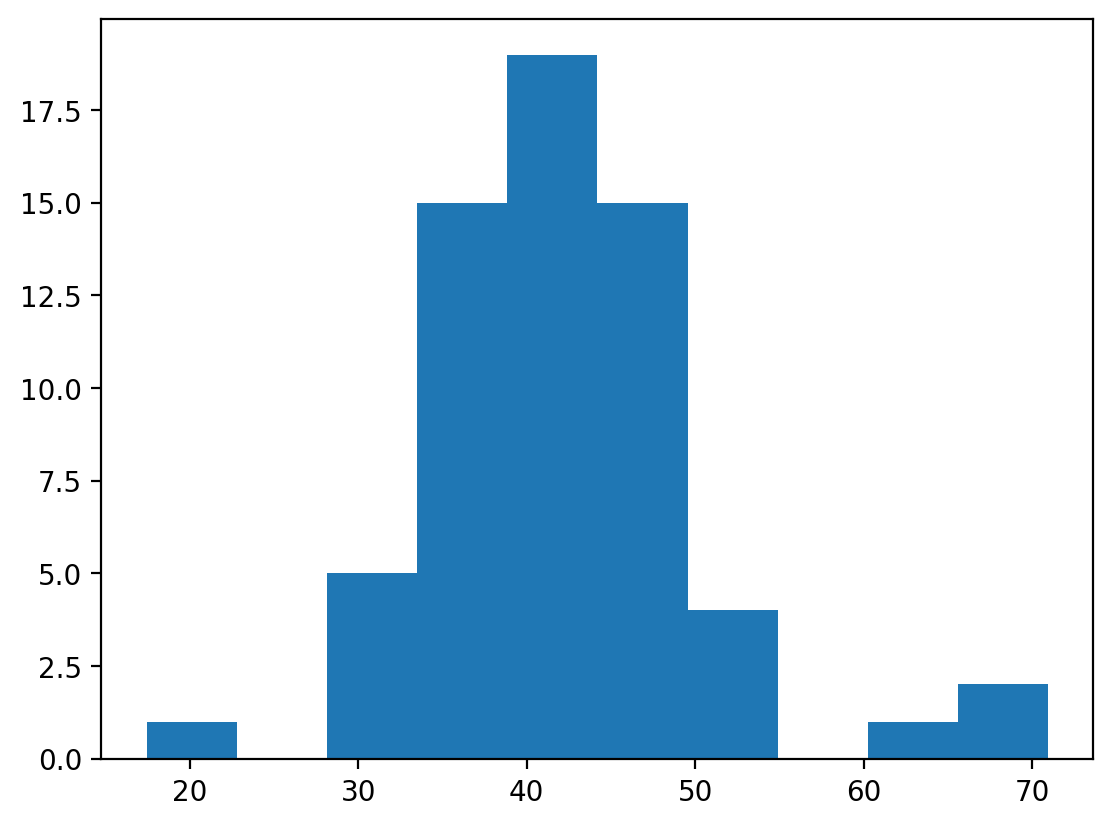

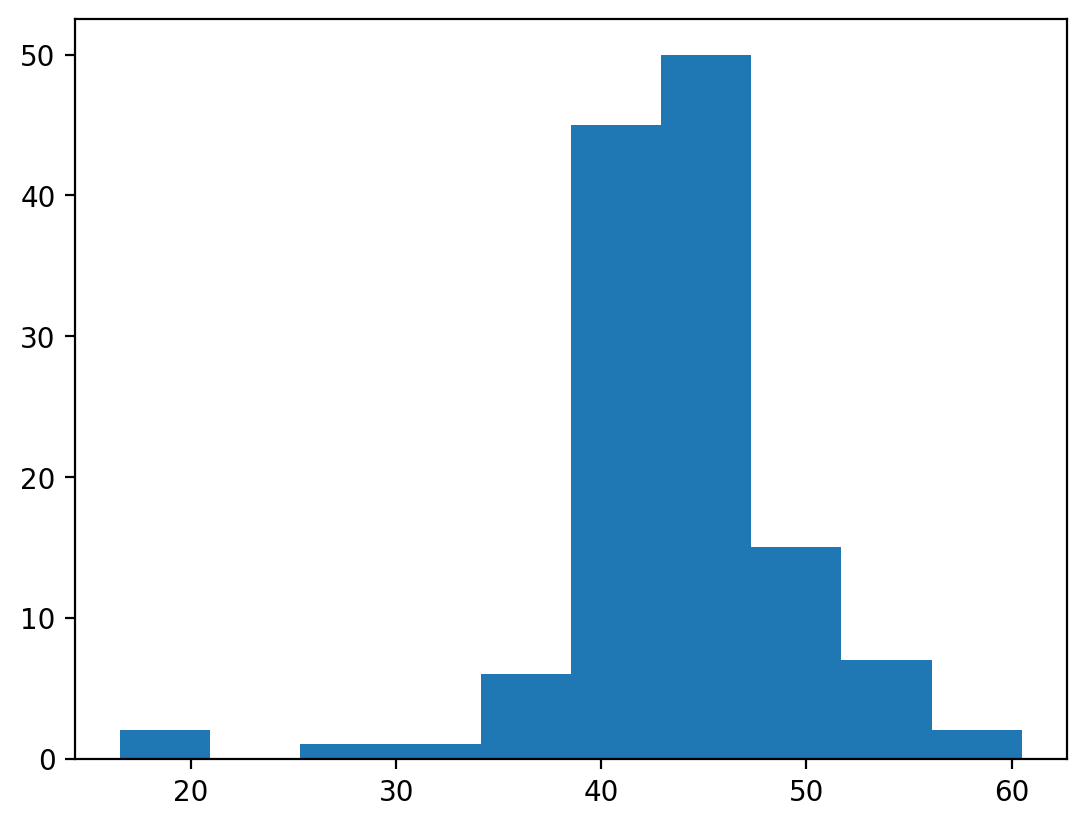

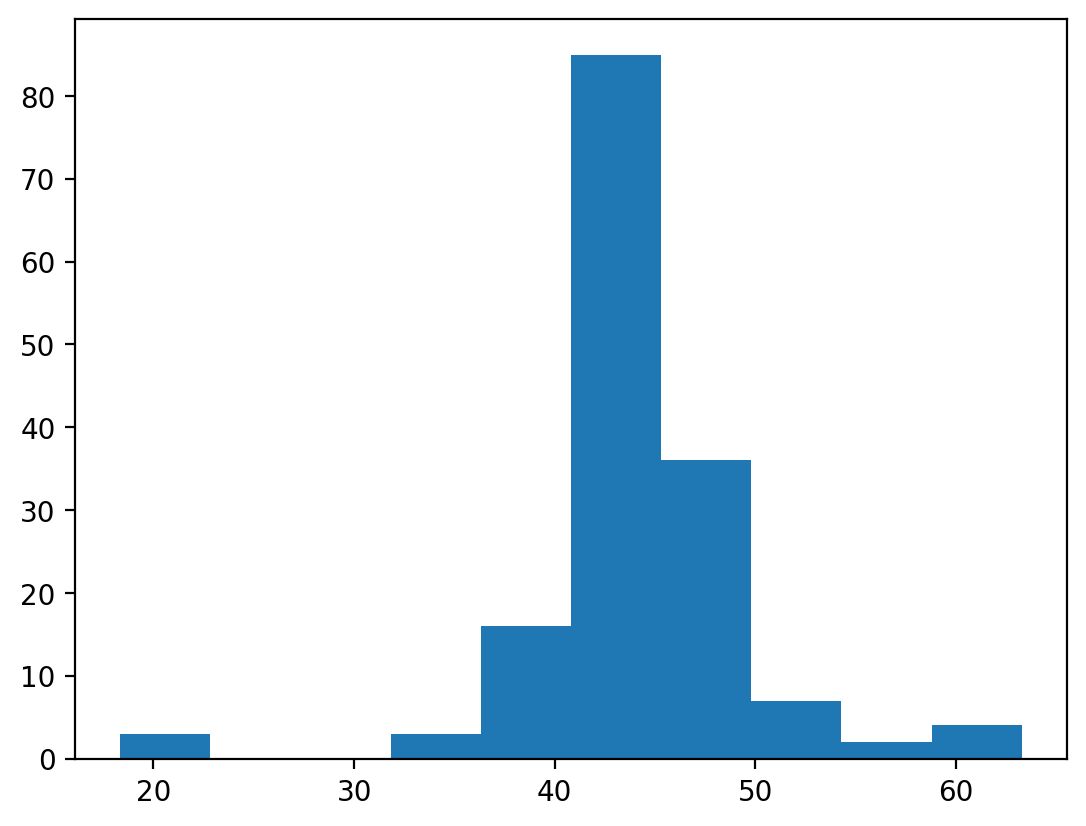

In [97]:
for pointing in pointings:
    rocks.analytic_propagate(pointing.epoch)
    obs = rocks.observe(o.at(pointing.epoch))
    keep = pointing.contains(obs) * (obs.mag < 26.5)
    rs = rocks.r[keep]
    fig, ax = plt.subplots()
    _ = plt.hist(rs)

In [15]:
%%timeit
rock.observe(o.at(pointing_0.epoch))

6.89 µs ± 17.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


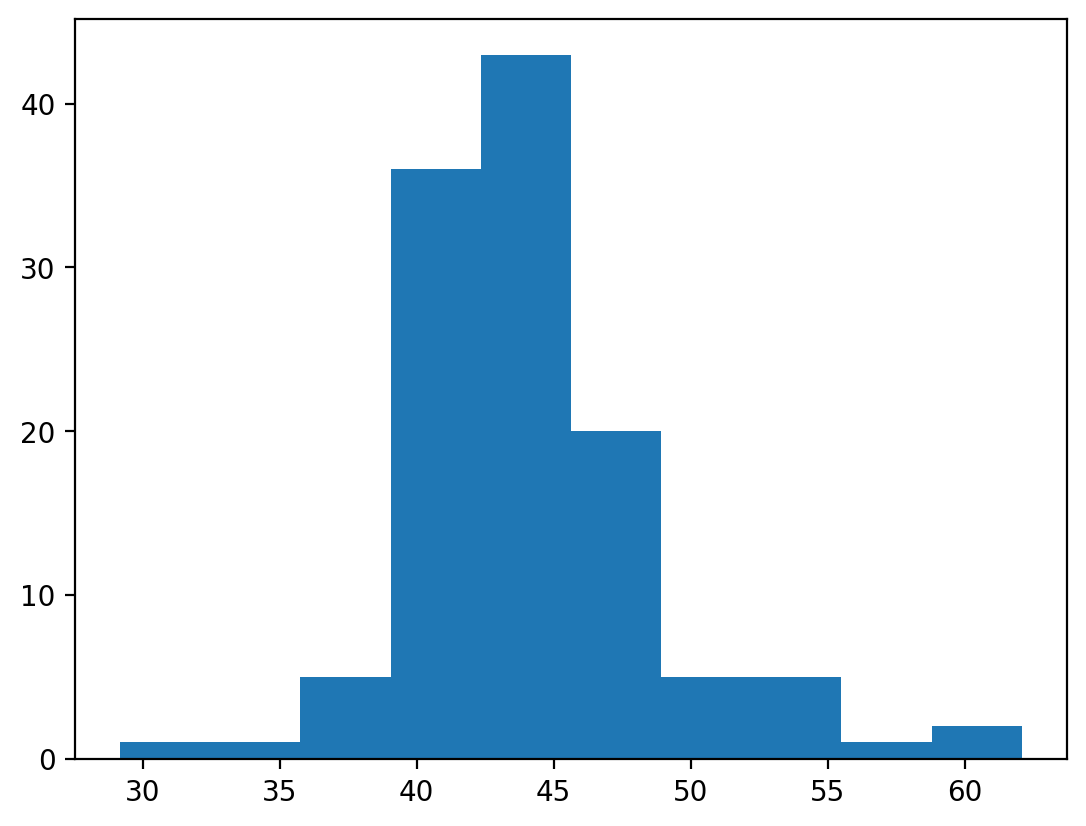

In [ ]:
for pointing in [deep_pointing]:
    rocks.analytic_propagate(pointing.epoch)
    obs = rocks.observe(o.at(pointing.epoch))
    keep = pointing.contains(obs) * (obs.mag < 26.5)
    rs = rocks.r[keep]
    fig, ax = plt.subplots()
    _ = plt.hist(rs)

In [20]:
ns = np.array(rocks.name)[keep]

In [21]:
len(ns)

119

In [12]:
rs = rocks.r[keep]

In [13]:
obs.mag[keep][rs > 68]

array([26.32630504450349], dtype=object)

In [15]:
np.array(rocks.name)[keep][rs > 68]

array(['d6d5b2e2440f4415b700198263ebcdad'], dtype=object)

In [29]:
model[model.objid == '60e6bc7501a0498eb997f5d1045bd5d6']

,a,e,inc,node,peri,Manom,H,Comments,objid
8902495,53.561,0.304,21.856,110.7,1.9,168.5,7.82,Classical--Extend--hot_o5c,60e6bc7501a0498eb997f5d1045bd5d6


In [30]:
model[model.objid == 'd6d5b2e2440f4415b700198263ebcdad']

,a,e,inc,node,peri,Manom,H,Comments,objid
18089938,55.205,0.321,17.978,114.3,12.7,143.3,7.78,Classical--Extend--hot_o5m,d6d5b2e2440f4415b700198263ebcdad


In [23]:
m = model.apply(lambda row: row.objid in ns, axis=1)

KeyboardInterrupt: 

In [30]:
model.objid.values

array(['2e04d28593b04c0696b604b6978768e1',
       'cb6781ba7cd6452fa2ee52ec34156efd',
       '154fba08bb374083a02e8aa35ebc2f33', ...,
       '0a1753eb6c4e462fb486dcd0eb78992a',
       '95e34fffa4f040298d11209d4f71660a',
       '14e6a9d42db04ab5a272130b697768e5'], dtype=object)

In [31]:
[n in model.objid.values for n in ns]

KeyboardInterrupt: 

In [33]:
m = model[np.in1d(model.objid.values, ns)]

In [38]:
set(m.Comments)

{'Classical--Bright--coldh_L4j',
 'Classical--Bright--coldh_L4v',
 'Classical--Bright--coldh_L5c',
 'Classical--Bright--coldh_L5i',
 'Classical--Bright--coldh_o3e',
 'Classical--Bright--coldh_o3l',
 'Classical--Bright--coldh_o4h',
 'Classical--Bright--coldh_o5c',
 'Classical--Bright--coldh_o5d',
 'Classical--Bright--coldh_o5p',
 'Classical--Bright--coldl_L3h',
 'Classical--Bright--coldl_L3w',
 'Classical--Bright--coldl_L4h',
 'Classical--Bright--coldl_L4k',
 'Classical--Bright--coldl_L4p',
 'Classical--Bright--coldl_L5i',
 'Classical--Bright--coldl_L7a',
 'Classical--Bright--coldl_o3e',
 'Classical--Bright--coldl_o3l',
 'Classical--Bright--coldl_o5c',
 'Classical--Bright--coldl_o5d',
 'Classical--Bright--coldl_o5p',
 'Classical--Bright--coldl_o5s',
 'Classical--Bright--coldl_o5t',
 'Classical--Bright--hot_L3y',
 'Classical--Bright--hot_L4k',
 'Classical--Bright--hot_mah',
 'Classical--Bright--hot_o3e',
 'Classical--Bright--hot_o3l',
 'Classical--Bright--hot_o3o',
 'Classical--Bright--h